## Problem statement : 
Credit card fraud is a serious issue , that costs millions of euros lost in germany each year , in fact ,  it is estimated that the losses reached 91 million euros in the year 2019 in germany alone , and  $24.2 billion globally ,it's considered a serious crime and it is one of the most common identity theft crimes, that has a huge burden on its victims.

solving this issue will help the credit card company protect their users and minimize their losses , which would also result in satisfied customers and help reduce criminal activity at the same time.

we can formulate this problem as a machine learning problem , by using historical transaction data as features and a binary label (FRAUD / NOT FRAUD)

this is considered a classification task , because our label y is categorical 

Link to the Dataset :https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn import metrics

In [20]:
# reading the dataset
df=pd.read_csv('card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


## Data Exploration
### in this step we will :
##### 1) get a basic overview of the data and some related statistics/information 
##### 2) check for correlated features ( in order to remove redundant columns)
##### 3) check the distrubution of the target to see if the dataset is inbalanced
##### 4) choose proper metrics

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [22]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
# ratio_median_purchase_price is correlated with fraud

corr=df.corr()
corr.style.background_gradient(cmap='coolwarm')

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.000000,0.000193,-0.001374,0.143124,-0.000697,-0.001622,-0.001301,0.187571
distance_from_last_transaction,0.000193,1.000000,0.001013,-0.000928,0.002055,-0.000899,0.000141,0.091917
ratio_to_median_purchase_price,-0.001374,0.001013,1.000000,0.001374,0.000587,0.000942,-0.000330,0.462305
repeat_retailer,0.143124,-0.000928,0.001374,1.000000,-0.001345,-0.000417,-0.000532,-0.001357
used_chip,-0.000697,0.002055,0.000587,-0.001345,1.000000,-0.001393,-0.000219,-0.060975
used_pin_number,-0.001622,-0.000899,0.000942,-0.000417,-0.001393,1.000000,-0.000291,-0.100293
online_order,-0.001301,0.000141,-0.000330,-0.000532,-0.000219,-0.000291,1.000000,0.191973
fraud,0.187571,0.091917,0.462305,-0.001357,-0.060975,-0.100293,0.191973,1.000000


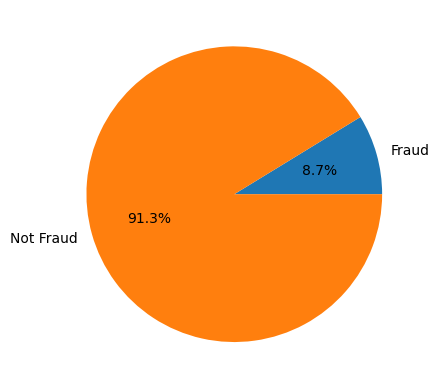

In [25]:
f_count = df[df["fraud"] == 1]["fraud"].count()
nf_count = df[df["fraud"] == 0]["fraud"].count()
plt.pie([f_count,nf_count],labels=['Fraud','Not Fraud'],autopct='%1.1f%%')
plt.show()

- we can see from the pie chart above that the dataset is extremly unbalanced, which is expected in this particular use case
- in order to solve this issue , we will reserve to either oversampling or undersampling , both have their strengths and weaknesses , undersampling will result in a loss of information , and oversampling might cause overfitting

##### The Metrics that we are going to use are : 
- Precision
- Recall
- F1-score 
- confusion matrix 

using accuracy score isn't going to be helpful in the case of an unbalanced dataset

## Data pre-processing
### in this step we will :
##### 1) deal with missing or duplicate values  , to make sure our model would work as intended
##### 2) split data into training and testing sets , in order to get a rough idea on how it would perform on unseen data
##### 3)  scale the data , since some models require scaling ( like logistic regression,knn etc...)
##### 4) apply oversampling on the training Data , to make sure its balanced without influencing testing data


In [26]:
# we can see that there are no mising values
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [27]:
# no duplicate values
df[df.duplicated()]

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud


In [28]:
# splitting target
x = df.drop("fraud", axis = 1).values
y = df["fraud"].astype("int8").values

In [29]:
# splitting train, test
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size = 0.2, stratify = y)

# we standarize the Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# we apply oversampling
smote = SMOTE(random_state=39)
X_over,y_over  = smote.fit_resample(X_train,y_train)


## Model Selection and hyper parameters
### in this step we will :
##### 1) use two different models(Decision trees and Logistic regression) , to compare their results and choose the best one
##### 2) for each model , use GridSearch to get the best parameters
##### 3) get the feature importance from each model , to better understand what features are being used during the classification task

In [30]:
# Hyper parameter tuning (GridSearchCV)
dt = DecisionTreeClassifier(random_state=42)
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "f1")

In [31]:
grid_search.fit(X_over,y_over)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='f1', verbose=1)

In [32]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       random_state=42)

In [33]:
clf = DecisionTreeClassifier(max_depth=10,min_samples_leaf=5, random_state=42)
clf = clf.fit(X_over,y_over)

In [34]:
y_pred_clf = clf.predict(X_test)

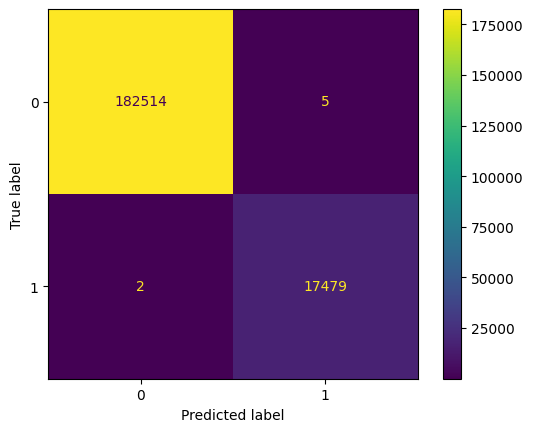

In [35]:
confusion_matrix_clf = confusion_matrix(y_test, y_pred_clf)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_clf)
disp.plot()

plt.show()

In [36]:

print(classification_report(y_test, y_pred_clf, digits=6))

              precision    recall  f1-score   support

           0   0.999989  0.999973  0.999981    182519
           1   0.999714  0.999886  0.999800     17481

    accuracy                       0.999965    200000
   macro avg   0.999852  0.999929  0.999890    200000
weighted avg   0.999965  0.999965  0.999965    200000



In [37]:
importance = clf.feature_importances_

# feature importance
column_names=df.columns[:-1].to_list()
for i,v in zip((importance),column_names):
    print(f'{v} : {i}')

distance_from_home : 0.264103939294679
distance_from_last_transaction : 0.11198457341226968
ratio_to_median_purchase_price : 0.51560182711627
repeat_retailer : 0.01376308747644447
used_chip : 0.02846608295029965
used_pin_number : 0.016441267031538545
online_order : 0.04963922271849871


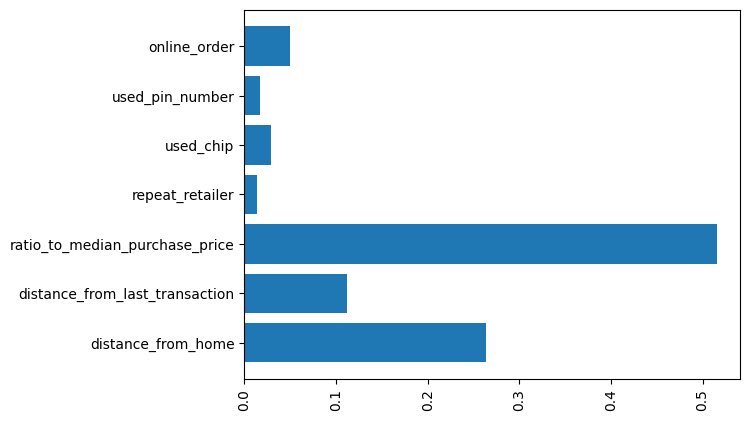

In [38]:
plt.barh(column_names,importance)
plt.xticks(rotation=90)
plt.show()

### As we can observe from the bar chart above , the three most important features are :
- ration_to_median_purchase_price
- distance_from_home
- distance_from_last_transaction

## We will repeat the same process for Logistic regression , to compare our models 

In [39]:
grid={"C":np.logspace(-3,3,7)}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=4,n_jobs=-1, verbose=1, scoring = "f1", )
logreg_cv.fit(X_over,y_over)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='f1', verbose=1)

In [40]:
logreg_cv.best_estimator_

LogisticRegression(C=np.float64(100.0))

In [41]:
clf2=LogisticRegression(C=np.float64(100.0))
clf2 = clf2.fit(X_over,y_over)
y_pred_clf2 = clf2.predict(X_test)

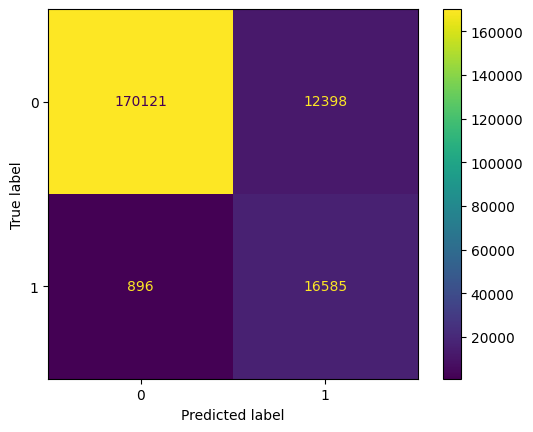

In [42]:
confusion_matrix_clf = confusion_matrix(y_test, y_pred_clf2)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_clf)
disp.plot()

plt.show()

In [43]:
print(classification_report(y_test, y_pred_clf2, digits=6))

              precision    recall  f1-score   support

           0   0.994761  0.932073  0.962397    182519
           1   0.572232  0.948744  0.713886     17481

    accuracy                       0.933530    200000
   macro avg   0.783496  0.940409  0.838142    200000
weighted avg   0.957830  0.933530  0.940676    200000



In [44]:
importance = clf2.coef_[0]
# feature importance
column_names=df.columns[:-1].to_list()
for i,v in zip((importance),column_names):
    print(f'{v} : {i}')

distance_from_home : 1.8695042907629744
distance_from_last_transaction : 1.3311462589043257
ratio_to_median_purchase_price : 3.388435657842116
repeat_retailer : -0.46021443424215375
used_chip : -0.5691675115451714
used_pin_number : -3.068761895958678
online_order : 2.40343711811095


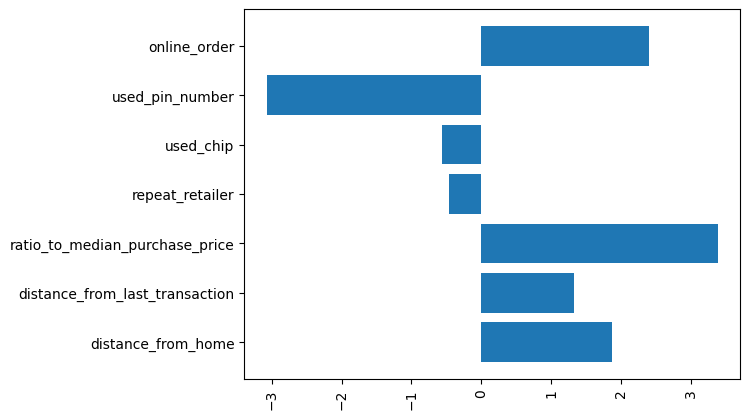

In [45]:
plt.barh(column_names,importance)
plt.xticks(rotation=90)
plt.show()

##### As we can observe from the bar chart above , the three most important features are :
- ration_to_median_purchase_price and online order were important for classifying class 1 (Fraud)
- used pin number feature was important classifying  class 0 (not fraud)  [1]

## Conclusion and Discussion
#### Result Discussion:
 Decision tree classifier outperformed Logistic regression in this particular setting , which might be due to the fact that Decision trees are less sensetive to noisy data and outliers
#### Strengths:
- Rhe proposed approached seems to be giving promising results while not requiring any extensive finetuning or high computation
- It has performed well across various metrics 
- The model itself is extremly fast in inference , which would prove viable in real time scenarios
#### Limitations:
- The model , although performed well , can still perform terribly in real life scenarios ,if the dataset itself is not representative enough of those scenarios
- If criminals somehow get to know the features involved into making the Algorithm , they can take extra steps to find loopholes
#### Data driven recommendations:
- Ensure high quality,representative Data
- Implement the pipeline in such a way to keep training the model even after deployment 
- Always check for state of the art and literrature review to stay updated with latest technological advancements 
#### Sources:
- [1]https://machinelearningmastery.com/calculate-feature-importance-with-python/
